In [ ]:
from google.colab import auth
auth.authenticate_user()
print('Authenticated')

%load_ext google.colab.data_table

Authenticated


Custom Engaged Sessions

In [ ]:
%%bigquery --project 

-- prep query to pull in all raw data
with prep as (
select
    user_pseudo_id,
    (select value.int_value from unnest(event_params) where key = 'ga_session_id') as session_id,
    event_name,
    event_timestamp,
    (select value.string_value from unnest(event_params) where event_name = 'page_view' and key = 'page_location') as pageview_location
from
    `ga.events_20210701`),

-- subquery to get all sessions with a length > 10 seconds
-- Sesja zaangażowana to sesja, która ma ponad 10 sekund
session_length as (
select
    user_pseudo_id,
    session_id,
    timestamp_seconds(session_id) as session_start_time,
    (max(event_timestamp)-min(event_timestamp))/1000000 as session_length_seconds
from
    prep
group by 
    user_pseudo_id,
    session_id
having 
    session_length_seconds > 10), -- To jest miejsce w którym mógłbym odflitrować większą / mniejszą wartość dla sesji liczonych w sekundach

-- subquery to get all sessions with 2 or more (unique) page views
-- Sesja zaangażowana to sesja, która ma 2 lub więcej wyświetleń strony
multiple_pageviews as (
select
    user_pseudo_id,
    session_id,
    timestamp_seconds(session_id) as session_start_time,
    pageview_location,
    row_number() over (partition by user_pseudo_id, session_id, pageview_location) - 1 as count_duplicate_pages,
    count(pageview_location) over (partition by user_pseudo_id,session_id) as unique_pageviews
from
    prep
where
    pageview_location is not null
group by 
    user_pseudo_id,
    session_id,
    pageview_location,
    event_timestamp
qualify 
    count_duplicate_pages = 0 -- Filtruje pierwsze wystąpienie strony per user
    and unique_pageviews >= 2), -- To jest miejsce w którym mógłbym odflitrować większą / mniejszą wartość dla unikalnych odsłon stony

-- subquery to get all sessions with a conversion event (in this example 'purchase')
-- Sesja zaangażowana to sesja, która ma zdarzenie konwersji
conversion_event as (
select
    user_pseudo_id,
    session_id,
    timestamp_seconds(session_id) as session_start_time, 
from
    prep
where 
    event_name = 'purchase'),

-- subquery to combine and deduplicate all subqueries generated earlier
dedup as (
select
    user_pseudo_id,
    session_id,
    session_start_time
from 
    session_length
union distinct
select
    user_pseudo_id,
    session_id,
    session_start_time
from 
    multiple_pageviews
group by 
    user_pseudo_id,
    session_id,
    session_start_time
union distinct
select
    user_pseudo_id,
    session_id,
    session_start_time
from 
    conversion_event)

-- main query to count unique engaged sessions by date in descending order
select
    date(session_start_time,"Europe/Helsinki") as date,
    count(distinct concat(user_pseudo_id,session_id)) as engaged_sessions
from
    dedup
group by 
    date
order by 
    date

,date,engaged_sessions
0,2021-06-30,9
1,2021-07-01,4046


Flatten GA4 Schema For Relational Databases

In [ ]:
%%bigquery --project 

-- Table 1: flat_events
select
    (select value.int_value from unnest(event_params) where key = 'ga_session_id') as ga_session_id,
    * except(event_params,user_properties,items),
    concat(user_pseudo_id,event_timestamp,event_name,row_number() over(partition by user_pseudo_id, event_timestamp, event_name)) as join_key
from
    `ga.events_20210701`;

-- Table 2: flat_event_params
with prep as (
select
    row_number() over(partition by user_pseudo_id, event_timestamp, event_name) as dedup_id,
    *
from
    `ga.events_20210701`),

prep_unnest as (
select 
    user_pseudo_id,
    case when event_params.key = 'ga_session_id' then event_params.value.int_value else null end as ga_session_id,
    event_timestamp,
    event_name,
    event_params.key,
    event_params.value.string_value,
    event_params.value.int_value,
    event_params.value.float_value,
    event_params.value.double_value,
    dedup_id
from
    prep,
    unnest(event_params) as event_params)

select
    max(ga_session_id) over (partition by event_timestamp,event_name) as ga_session_id,
    * except(ga_session_id,dedup_id),
    concat(user_pseudo_id,event_timestamp,event_name,dedup_id) as join_key
from
    prep_unnest;

-- Table 3: flat_user_properties
with prep as (
select 
    row_number() over(partition by user_pseudo_id, event_timestamp, event_name) as dedup_id,
    *
from
    `ga.events_20210701`)

select 
    user_pseudo_id,
    event_timestamp,
    event_name,
    user_properties.key,
    user_properties.value.string_value,
    user_properties.value.int_value,
    user_properties.value.float_value,
    user_properties.value.double_value,
    user_properties.value.set_timestamp_micros,
    concat(user_pseudo_id,event_timestamp,event_name,dedup_id) as join_key
from
    prep,
    unnest(user_properties) as user_properties;

-- Table 4: flat_items
with prep as (
select
    row_number() over(partition by user_pseudo_id, event_timestamp, event_name) as dedup_id,
    *
from
    `ga.events_20210701`)

select
    user_pseudo_id,
    event_timestamp,
    event_name,
    items.item_id,
    items.item_name,
    items.item_brand,
    items.item_variant,
    items.item_category,
    items.item_category2,
    items.item_category3,
    items.item_category4,
    items.item_category5,
    items.price_in_usd,
    items.price,
    items.quantity,
    items.item_revenue_in_usd,
    items.item_revenue,
    items.item_refund_in_usd,
    items.item_refund,
    items.coupon,
    items.affiliation,
    items.location_id,
    items.item_list_id,
    items.item_list_name,
    items.item_list_index,
    items.promotion_id,
    items.promotion_name,
    items.creative_name,
    items.creative_slot,
    concat(user_pseudo_id,event_timestamp,event_name,dedup_id) as join_key
from 
    prep,
    unnest(items) as items

,user_pseudo_id,event_timestamp,event_name,item_id,item_name,item_brand,item_variant,item_category,item_category2,item_category3,item_category4,item_category5,price_in_usd,price,quantity,item_revenue_in_usd,item_revenue,item_refund_in_usd,item_refund,coupon,affiliation,location_id,item_list_id,item_list_name,item_list_index,promotion_id,promotion_name,creative_name,creative_slot,join_key
0,1002517746.1625085139,1625137777692615,add_to_cart,I0dUTVRpcHM6IERlbGF5IFRoZSA=,#GTMTips:DelayTheHistoryChangeTrigger,TRIGGER,medium,#GTMTips:,Delay,The,(not set),(not set),NaN,42.0,1.0,NaN,NaN,None,None,(not set),(not set),(not set),(not set),(not set),(not set),(not set),(not set),(not set),(not set),1002517746.16250851391625137777692615add_to_cart1
1,1009681121.1613035007,1625142996825440,view_promotion,(not set),(not set),(not set),(not set),(not set),(not set),(not set),(not set),(not set),NaN,NaN,NaN,NaN,NaN,None,None,(not set),(not set),article,(not set),(not set),(not set),newsletter,Newsletter Promo,newsletter_creative,main_slot,1009681121.16130350071625142996825440view_prom...
2,1024426273.1620825093,1625172545423767,add_shipping_info,VGhlIFlvdVR1YmUgVmlkZW8gVHI=,TheYouTubeVideoTriggerInGoogleTagManager,MANAGER,medium,The,YouTube,Video,(not set),(not set),NaN,47.0,1.0,NaN,NaN,None,None,(not set),(not set),(not set),(not set),(not set),(not set),(not set),(not set),(not set),(not set),1024426273.16208250931625172545423767add_shipp...
3,1024426273.1620825093,1625172545423767,add_shipping_info,clQgb2VkaVYgZWJ1VHVvWSBlaFQ=,The_YouTube_V1deo_Tr1gger_In_Google_Tag_Manager,RECENT,small,Video,(not set),(not set),(not set),(not set),NaN,94.0,1.0,NaN,NaN,None,None,(not set),(not set),(not set),(not set),(not set),(not set),(not set),(not set),(not set),(not set),1024426273.16208250931625172545423767add_shipp...
4,1035504174.1607465605,1625094527207012,view_item,I0dUTXRpcHM6IE9uY2UgdXNlckk=,"#GTMtips:OnceuserId,AlwaysuserId",USERID,medium,#GTMtips:,Once,"userId,",(not set),(not set),NaN,36.0,1.0,NaN,NaN,None,None,(not set),(not set),(not set),(not set),(not set),(not set),(not set),(not set),(not set),(not set),1035504174.16074656051625094527207012view_item1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45374,gc3RuuLE2o2Vdm4rq2rkG/6oUy7GvuW1WmOe86jbmEk=.1...,1625141804458335,view_item,U2VydmVyLXNpZGUgVGFnZ2luZyA=,Server-sideTaggingInGoogleTagManager,MANAGER,medium,Server-side,Tagging,In,(not set),(not set),NaN,41.0,1.0,NaN,NaN,None,None,(not set),(not set),(not set),(not set),(not set),(not set),(not set),(not set),(not set),(not set),gc3RuuLE2o2Vdm4rq2rkG/6oUy7GvuW1WmOe86jbmEk=.1...
45375,hqxUc649RHU72RhcDUuoJRBSz6HjFXm9UvyHRs9d4xQ=.1...,1625128100722497,add_payment_info,I0dUTVRpcHM6IEFjY2VzcyBBcnI=,#GTMTips:AccessArrayMembersInTheDataLayer,LAYER,medium,#GTMTips:,Access,Array,(not set),(not set),NaN,48.0,1.0,NaN,NaN,None,None,(not set),(not set),(not set),(not set),(not set),(not set),(not set),(not set),(not set),(not set),hqxUc649RHU72RhcDUuoJRBSz6HjFXm9UvyHRs9d4xQ=.1...
45376,hqxUc649RHU72RhcDUuoJRBSz6HjFXm9UvyHRs9d4xQ=.1...,1625131763490694,add_to_cart,I0dUTVRpcHM6IEFjY2VzcyBBcnI=,#GTMTips:AccessArrayMembersInTheDataLayer,LAYER,medium,#GTMTips:,Access,Array,(not set),(not set),NaN,48.0,1.0,NaN,NaN,None,None,(not set),(not set),(not set),(not set),(not set),(not set),(not set),(not set),(not set),(not set),hqxUc649RHU72RhcDUuoJRBSz6HjFXm9UvyHRs9d4xQ=.1...
45377,oKUe/UhEEMMMwT1lxFsCMmk9UE94sh2JGqEaqQX9/XI=.1...,1625092774087505,view_promotion,(not set),(not set),(not set),(not set),(not set),(not set),(not set),(not set),(not set),NaN,NaN,NaN,NaN,NaN,None,None,(not set),(not set),page,(not set),(not set),(not set),newsletter,Newsletter Promo,newsletter_creative,main_slot,oKUe/UhEEMMMwT1lxFsCMmk9UE94sh2JGqEaqQX9/XI=.1...


In [ ]:
%%bigquery --project 

select
    device.category,
    count(distinct events.user_pseudo_id) as users,
    count(distinct concat(events.user_pseudo_id,events.ga_session_id)) as sessions,
    count(distinct case when user_properties.key = 'visitor_status' and user_properties.string_value = 'buyer' then user_properties.user_pseudo_id else null end) as buyers,
    count(distinct case when event_params.key = 'engagement_time_msec' and event_params.int_value > 0 then event_params.user_pseudo_id else null end) as active_users,
    count(distinct case when items.event_name = 'add_to_cart' then concat(events.user_pseudo_id,events.ga_session_id) else null end) as sessions_with_add_to_cart
from 
    `bigquery-ga4-course.ga4_flat.flat_events` as events
    left join `bigquery-ga4-course.ga4_flat.flat_user_properties` as user_properties on events.join_key = user_properties.join_key
    left join `bigquery-ga4-course.ga4_flat.flat_event_params` as event_params on events.join_key = event_params.join_key
    left join `bigquery-ga4-course.ga4_flat.flat_items` as items on events.join_key = items.join_key
group by 
    category

Join GA4 With Public Weather Data

Kod stacji pogodowej dla Opola to 125300

Data transfer

https://cloud.google.com/bigquery-transfer/docs/introduction

In [ ]:
%%bigquery --project 

with date_range as (
select
    date('2021-07-01') as start_date,
    date('2021-07-15') as end_date)

select
    date(cast(year as int64),cast(mo as int64),cast(da as int64)) as date,
    case when temp = 9999.9 then null else temp end as temperature_fahrenheit_mean,
    case when max = 9999.9 then null else temp end as temperature_fahrenheit_max,
    case when min = 9999.9 then null else temp end as temperature_fahrenheit_min,
    case when visib = 999.9 then null else visib end as visibility_mi,
    case when wdsp = '999.9' then null else wdsp end as wind_speed_kn,
    case when prcp = 99.99 then null else prcp end as precipitation_in,
    case when sndp = 999.9 then 0.0 else sndp end as snow_depth_in,
    case when temp = 9999.9 then null else round((temp - 32) * (5/9),1) end as temperature_celcius_mean,
    case when max = 9999.9 then null else round((max - 32) * (5/9),1) end as temperature_celcius_max,
    case when min = 9999.9 then null else round((min - 32) * (5/9),1) end as temperature_celcius_min,
    case when visib = 999.9 then null else round(visib * 1.609,1) end as visibility_km,
    case when wdsp = '999.9' then null else round(cast(wdsp as float64) * 1.852,1) end as wind_speed_kmh,
    case when prcp = 99.99 then null else round(prcp * 25.4,1) end as precipitation_mm,
    case when sndp = 999.9 then 0.0 else round(sndp * 25.4,1) end as snow_depth_mm,
    fog,
    rain_drizzle,
    hail,
    thunder
from
    `bigquery-public-data.noaa_gsod.gsod*`,
    date_range
where
    _table_suffix between cast(extract(year from start_date) as string) and cast(extract(year from end_date) as string)
    and date(cast(year as int64),cast(mo as int64),cast(da as int64)) >= start_date
    and date(cast(year as int64),cast(mo as int64),cast(da as int64)) <= end_date
    and stn = '125300'
order by
    date

,date,temperature_fahrenheit_mean,temperature_fahrenheit_max,temperature_fahrenheit_min,visibility_mi,wind_speed_kn,precipitation_in,snow_depth_in,temperature_celcius_mean,temperature_celcius_max,temperature_celcius_min,visibility_km,wind_speed_kmh,precipitation_mm,snow_depth_mm,fog,rain_drizzle,hail,thunder
0,2021-07-01,65.3,65.3,65.3,12.3,3.9,0.00,0.0,18.5,22.9,15.5,19.8,7.2,0.0,0.0,1,0,0,0
1,2021-07-02,64.8,64.8,64.8,15.0,4.3,NaN,0.0,18.2,22.8,15.2,24.1,8.0,NaN,0.0,1,0,0,0
2,2021-07-03,67.0,67.0,67.0,15.4,5.6,0.00,0.0,19.4,24.8,14.0,24.8,10.4,0.0,0.0,0,0,0,0
3,2021-07-04,68.2,68.2,68.2,15.3,1.8,0.00,0.0,20.1,27.3,11.3,24.6,3.3,0.0,0.0,0,0,0,0
4,2021-07-05,69.3,69.3,69.3,14.1,2.9,NaN,0.0,20.7,27.3,12.6,22.7,5.4,NaN,0.0,1,0,0,0
5,2021-07-06,73.3,73.3,73.3,13.2,4.4,0.00,0.0,22.9,29.8,13.9,21.2,8.1,0.0,0.0,0,0,0,0
6,2021-07-07,71.7,71.7,71.7,18.4,4.7,NaN,0.0,22.1,30.7,16.1,29.6,8.7,NaN,0.0,1,0,0,0
7,2021-07-08,68.3,68.3,68.3,10.0,2.6,0.39,0.0,20.2,26.3,16.1,16.1,4.8,9.9,0.0,1,0,1,0
8,2021-07-09,70.0,70.0,70.0,11.1,4,0.60,0.0,21.1,25.0,17.3,17.9,7.4,15.2,0.0,1,0,1,0
9,2021-07-10,66.7,66.7,66.7,15.3,3.4,0.00,0.0,19.3,24.8,14.6,24.6,6.3,0.0,0.0,0,0,0,0


In [ ]:
%%bigquery --project 

with date_range as (
select
    date('2021-07-01') as start_date,
    date('2021-07-15') as end_date),

weather as (select
    date(cast(year as int64),cast(mo as int64),cast(da as int64)) as date,
    case when temp = 9999.9 then null else temp end as temperature_fahrenheit_mean,
    case when max = 9999.9 then null else temp end as temperature_fahrenheit_max,
    case when min = 9999.9 then null else temp end as temperature_fahrenheit_min,
    case when visib = 999.9 then null else visib end as visibility_mi,
    case when wdsp = '999.9' then null else wdsp end as wind_speed_kn,
    case when prcp = 99.99 then null else prcp end as precipitation_in,
    case when sndp = 999.9 then 0.0 else sndp end as snow_depth_in,
    case when temp = 9999.9 then null else round((temp - 32) * (5/9),1) end as temperature_celcius_mean,
    case when max = 9999.9 then null else round((max - 32) * (5/9),1) end as temperature_celcius_max,
    case when min = 9999.9 then null else round((min - 32) * (5/9),1) end as temperature_celcius_min,
    case when visib = 999.9 then null else round(visib * 1.609,1) end as visibility_km,
    case when wdsp = '999.9' then null else round(cast(wdsp as float64) * 1.852,1) end as wind_speed_kmh,
    case when prcp = 99.99 then null else round(prcp * 25.4,1) end as precipitation_mm,
    case when sndp = 999.9 then 0.0 else round(sndp * 25.4,1) end as snow_depth_mm,
    fog,
    rain_drizzle,
    hail,
    thunder
from
    `produkcja-instore.view.gsod*`,
    date_range
where
    _table_suffix between cast(extract(year from start_date) as string) and cast(extract(year from end_date) as string)
    and date(cast(year as int64),cast(mo as int64),cast(da as int64)) >= start_date
    and date(cast(year as int64),cast(mo as int64),cast(da as int64)) <= end_date
    and stn = '125300'
order by
    date)

select
    events.event_date,
    count(distinct concat(user_pseudo_id, (select value.int_value from unnest(event_params) where key = 'ga_session_id'))) as sessions,
    count(distinct ecommerce.transaction_id) as transactions,
    ifnull(sum(ecommerce.purchase_revenue),0) as purchase_revenue,
    max(weather.temperature_celcius_mean) as temperature_celcius_mean,
    max(weather.precipitation_mm) as precipitation_mm,
    max(weather.wind_speed_kmh) as wind_speed_kmh
from
    `simoahava-com.analytics_206575074.events_*` as events,
    date_range
    left join weather on events.event_date = format_date('%Y%m%d',weather.date)
where
    _table_suffix between format_date('%Y%m%d',date_range.start_date) and format_date('%Y%m%d',date_range.end_date)
group by
    event_date
order by
    event_date desc

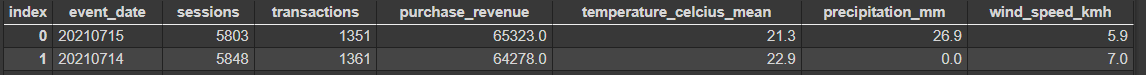